This notebook is to test the optimization of the test locations V, W in NFSIC.

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import fsic.util as util
import fsic.data as data
import fsic.kernel as kernel
import fsic.indtest as it
import scipy.stats as stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 14
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [19]:
def get_quad_psfunc():
    """
    Return a PairedSource to generate y = x^2 + Gaussian noise.
    """
    mean = 2
    width = 6
    px = lambda n: stats.uniform.rvs(loc=mean-width/2, scale=width, size=n)[:, np.newaxis]
    f = lambda x: 0.3*(x-1)**2 + 0.3*np.random.randn(n, 1)
    #f = lambda x: x
    return data.PSFunc(f, px)


In [20]:
# paired source 
alpha = 0.01
n = 1000
dx = 50
dy = 5
seed = 339
ps = data.PSIndSameGauss(dx, dy)
#ps = data.PS2DUnifRotate(angle=np.pi/4)
#ps = data.PSUnifRotateNoise(angle=np.pi/3, noise_dim=2)
#ps = get_quad_psfunc()
#ps = data.PSIndUnif(xlb=[0, 3], xub=[1, 10], ylb=[-5, 5], yub=[8, 10])
#ps = data.PS2DSinFreq(freq=2)

pdata = ps.sample(n, seed=seed)
tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=seed+5)

Text(0, 0.5, '$Y$')

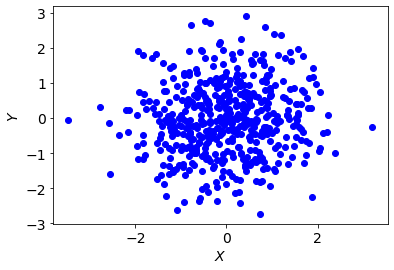

In [21]:
# plot the data. Assume 2d. Plot the first dimensions of X and Y.
xtr, ytr = tr.xy()
plt.plot(xtr[:, 0], ytr[:, 0], 'ob')
plt.xlabel('$X$')
plt.ylabel('$Y$')

## Grid search for Gaussian widths. Random test locations

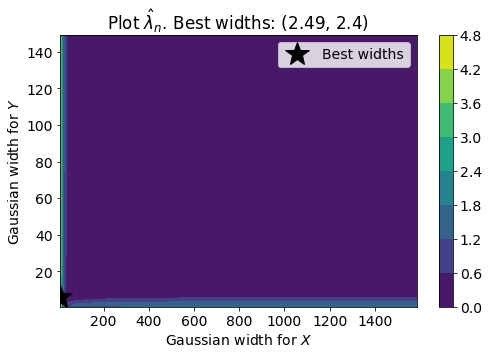

In [22]:
J = 2

V, W = it.GaussNFSIC.init_locs_2randn(tr, J, seed=seed+1)
X, Y = tr.xy()
n_gwidth_cand = 30
gwidthx_factors = 2.0**np.linspace(-4, 4, n_gwidth_cand) 
gwidthy_factors = gwidthx_factors
#gwidthy_factors = 2.0**np.linspace(-3, 4, 40) 
medx = util.sampled_median_distance(X, 1000)
medy = util.sampled_median_distance(Y, 1000)
list_gwidthx = np.hstack( ( (medx**2)*gwidthx_factors ) )
list_gwidthy = np.hstack( ( (medy**2)*gwidthy_factors ) )

bestij, lambs = it.GaussNFSIC.grid_search_gwidth(tr, V, W, list_gwidthx, list_gwidthy)
# These are width^2
best_widthx = list_gwidthx[bestij[0]]
best_widthy = list_gwidthy[bestij[1]]
# plot
Candy, Candx = np.meshgrid(list_gwidthy, list_gwidthx)
plt.figure(figsize=(8,5))
plt.contourf(Candx, Candy, lambs)
plt.plot(best_widthx, best_widthy, '*k', markersize=25, label='Best widths')
plt.xlabel('Gaussian width for $X$')
plt.ylabel('Gaussian width for $Y$')
plt.title('Plot $\hat{\lambda}_n$. Best widths: (%.3g, %.3g)'
          %(best_widthx**0.5, best_widthy**0.5))
plt.legend(numpoints=1)
plt.colorbar()

In [23]:
# perform test
nfsic_grid = it.GaussNFSIC(best_widthx, best_widthy, V, W, alpha)
test_result = nfsic_grid.perform_test(te)
test_result

{'alpha': 0.01,
 'pvalue': 0.6954920962667803,
 'test_stat': 0.7262712635712241,
 'h0_rejected': False,
 'time_secs': 0.0008635520935058594}

## Optimize the test locations V, W and Gaussian widths

In [24]:
op = {'n_test_locs':J, 'max_iter':400,
    'V_step':1, 'W_step':1, 'gwidthx_step':1, 'gwidthy_step':1,
    'batch_proportion':0.7, 'tol_fun':1e-4, 'step_pow':0.5, 'seed':seed+7}
op_V, op_W, op_gwx, op_gwy, info = it.GaussNFSIC.optimize_locs_widths(tr, alpha, **op )

In [25]:
# perform test
nfsic_full = it.GaussNFSIC(op_gwx, op_gwy, op_V, op_W, alpha)
nfsic_full.perform_test(te)

{'alpha': 0.01,
 'pvalue': 0.34466427020209817,
 'test_stat': 2.1303689311960463,
 'h0_rejected': False,
 'time_secs': 0.0006363391876220703}

Text(0, 0.5, 'dim 0 of W')

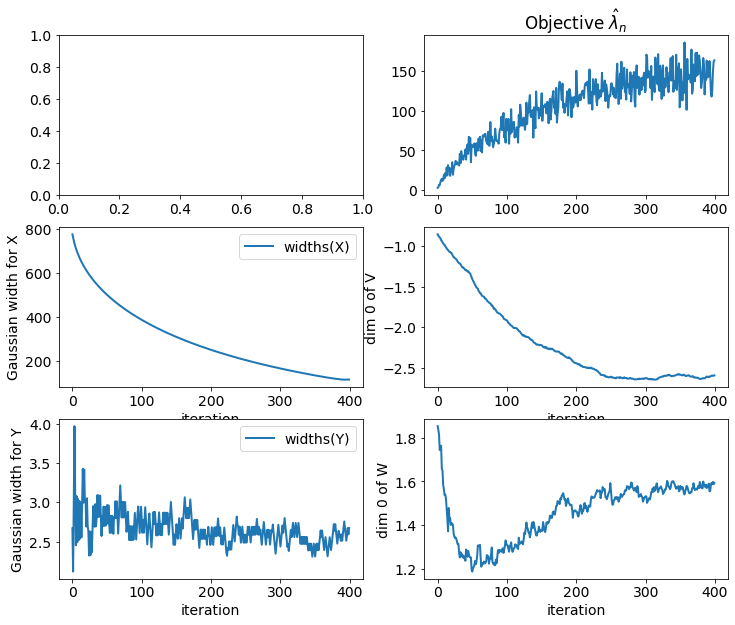

In [26]:
# Plot evolution of the test locations, Gaussian width

# trajectories of the Gaussian widths
gwidthxs = info['gwidthxs']
gwidthys = info['gwidthys']
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

axs[1, 0].plot(gwidthxs, label='widths(X)')
#axs[0, 0].plot(gwidthys, label='widths(Y)')
axs[1, 0].set_xlabel('iteration')
axs[1, 0].set_ylabel('Gaussian width for X')
axs[1, 0].legend()
#axs[0, 0].set_title('Gaussian width evolution')

axs[2, 0].plot(gwidthys, label='widths(Y)')
axs[2, 0].set_xlabel('iteration')
axs[2, 0].set_ylabel('Gaussian width for Y')
axs[2, 0].legend()

# evolution of objective values
objs = info['obj_values']
axs[0, 1].plot(objs)
axs[0, 1].set_title('Objective $\hat{\lambda}_n$')

# trajectories of the test locations
# iters x J. X Coordinates of all test locations
Vs = info['Vs']
vs = Vs[:, 0, 0]
axs[1, 1].plot(vs)
axs[1, 1].set_xlabel('iteration')
axs[1, 1].set_ylabel('dim 0 of V')

Ws = info['Ws']
ws = Ws[:, 0, 0]
axs[2, 1].plot(ws)
axs[2, 1].set_xlabel('iteration')
axs[2, 1].set_ylabel('dim 0 of W')

In [27]:
print('medx2: %g'%medx**2)
print('medy2: %g'%medy**2)
print('optimized gwx: %g'%info['gwidthxs'][-1])
print('optimized gwy: %g'%info['gwidthys'][-1])
print('optimized + bounding gwx: %g'%op_gwx)
print('optimized + bounding gwy: %g'%op_gwy)

medx2: 99.0858
medy2: 9.32755
optimized gwx: 114.244
optimized gwy: 2.67213
optimized + bounding gwx: 114.244
optimized + bounding gwy: 2.67213


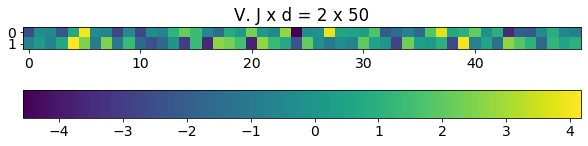

In [28]:
V = nfsic_full.V
W = nfsic_full.W

# plot
plt.figure(figsize=(10, 5))
plt.imshow(V, interpolation='none')
plt.title('V. J x d = %d x %d'%(V.shape[0], V.shape[1]))
plt.colorbar(orientation='horizontal')

Text(0.5, 1.0, 'Consider location 0. dx = 50.')

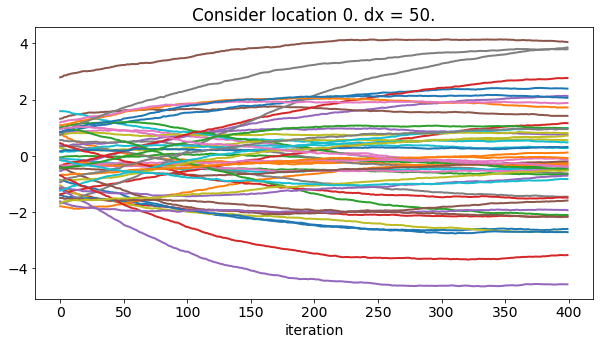

In [29]:
loc_ind = 0
# Vs: #iters x J x d
plt.figure(figsize=(10, 5))
plt.plot(Vs[:, loc_ind, :]);
plt.xlabel('iteration')
plt.title('Consider location %d. dx = %d.'%(loc_ind, Vs.shape[2]) )

Text(0.5, 1.0, 'Consider dim 0. All 2 locations of X')

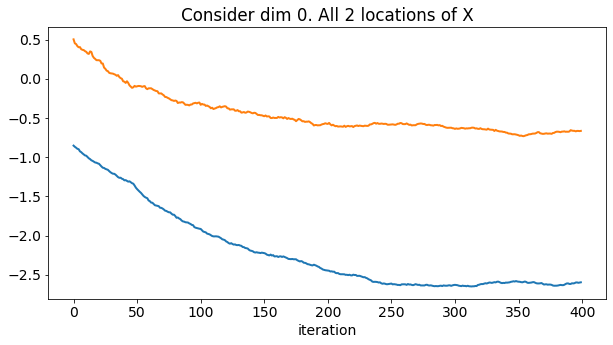

In [30]:
dim = 0
plt.figure(figsize=(10, 5))
plt.plot(Vs[:, :, dim]);
plt.xlabel('iteration')
plt.title('Consider dim %d. All %d locations of X'%(dim, J))

## Test power + optimization

In [31]:

reps = 50
n = 1000
J = 10
alpha = 0.05
# None = use aymptotics
n_permute = None
#n_permute = 200

ps = data.PSIndSameGauss(dx=20, dy=20)

def run_trial(r):
    """
    r: repetition number
    Return the resulting GaussNFSIC object, optimization info
    """
    
    print('starting rep: %d'%(r+1))
    pdata = ps.sample(n, seed=r)
    tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=r+87)
    nfsic_opt_options = {'n_test_locs':J, 'max_iter':200,
        'V_step':1, 'W_step':1, 'gwidthx_step':1, 'gwidthy_step':1,
        'batch_proportion':0.7, 'tol_fun':1e-3, 'step_pow':0.5, 'seed':r+2,
        'reg': 1e-6}
    #V, W = it.GaussNFSIC.init_locs_joint_subset(pdata2, J, seed=r+1)
    #V, W = it.GaussNFSIC.init_locs_2randn(pdata, J, seed=r+3)

    op_V, op_W, op_gwx, op_gwy, info = it.GaussNFSIC.optimize_locs_widths(tr,
        alpha, **nfsic_opt_options )
    nfsic_opt = it.GaussNFSIC(op_gwx, op_gwy, op_V, op_W, alpha=alpha,
                              reg='auto', n_permute=n_permute, seed=r+3)
    return nfsic_opt, info

In [32]:
#from multiprocessing.dummy import Pool as ThreadPool
#threads = 4
#pool = ThreadPool(threads)
#rep_nfsics = pool.map(run_trial, range(reps))
opt_infos = []
rep_nfsics = []
for r in range(reps):
    nf, info = run_trial(r)
    opt_infos.append(info)
    rep_nfsics.append(nf)
    

starting rep: 1
starting rep: 2
starting rep: 3
starting rep: 4
starting rep: 5
starting rep: 6
starting rep: 7
starting rep: 8
starting rep: 9
starting rep: 10
starting rep: 11
starting rep: 12
starting rep: 13
starting rep: 14
starting rep: 15
starting rep: 16
starting rep: 17
starting rep: 18
starting rep: 19
starting rep: 20
starting rep: 21
starting rep: 22
starting rep: 23
starting rep: 24
starting rep: 25
starting rep: 26
starting rep: 27
starting rep: 28
starting rep: 29
starting rep: 30
starting rep: 31
starting rep: 32
starting rep: 33
starting rep: 34
starting rep: 35
starting rep: 36
starting rep: 37
starting rep: 38
starting rep: 39
starting rep: 40
starting rep: 41
starting rep: 42
starting rep: 43
starting rep: 44
starting rep: 45
starting rep: 46
starting rep: 47
starting rep: 48
starting rep: 49
starting rep: 50


In [33]:
test_results = np.zeros(reps, dtype=object)
for r in range(reps):
    nfsic = rep_nfsics[r]
    pdata = ps.sample(4000, seed=r+1)
    tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=r+87)
    
    nfsic_result  = nfsic.perform_test(te)
    test_results[r] = nfsic_result
    
    # sequence of power
    #rejs = [re['h0_rejected'] for re in test_results[:(r+1)]]
    #print 'power at rep %3d: %5.4g, #rejs: %3d'%(r+1, np.mean(rejs), np.sum(rejs))

In [36]:
rejs = np.array([r['h0_rejected'] for r in test_results])
rep_stats = np.array([r['test_stat'] for r in test_results])
thresh = stats.chi2.isf(alpha, df=J)

power = np.mean(rejs)
print('power: %g'%power)

power: 0.08


In [37]:
np.where(np.isnan(rep_stats))

(array([], dtype=int64),)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


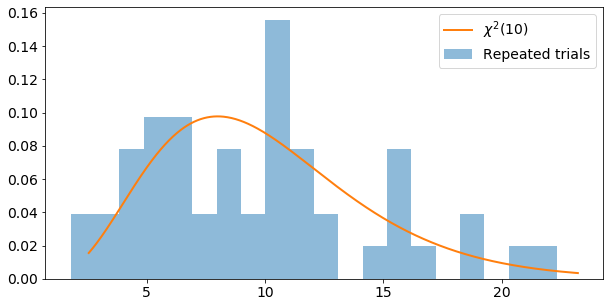

In [38]:
# histogram
dom = np.linspace(stats.chi2.isf(0.99, df=J), stats.chi2.isf(0.01, df=J), 600)
chi2_den = stats.chi2.pdf(dom, df=J)

plt.figure(figsize=(10, 5))
plt.hist(rep_stats[np.isfinite(rep_stats)], bins=20, 
         alpha=0.5, label='Repeated trials', normed=True)
plt.plot(dom, chi2_den, '-', label=r'$\chi^2(%d)$'%J)
plt.legend()


In [39]:
# check optimized locations
def plot_opt_VW_trial(r):
    nf = rep_nfsics[r]
    V = nf.V
    W = nf.W
    VW = np.hstack((V, W))
    VW = VW[np.isfinite(np.sum(VW,1))]
    #print VW
    # plot
    plt.plot(VW[:, 0], VW[:, 1], 'o')
    plt.xlabel('V')
    plt.ylabel('W')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.title('trial: %d, #locs: %d'%(r, VW.shape[0]))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plot_opt_VW_trial>

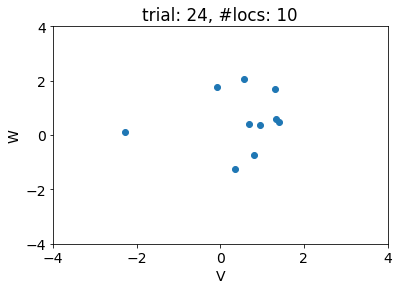

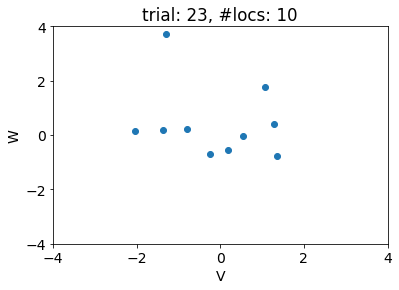

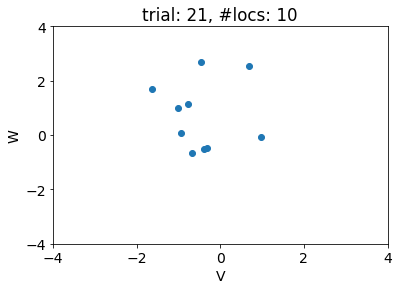

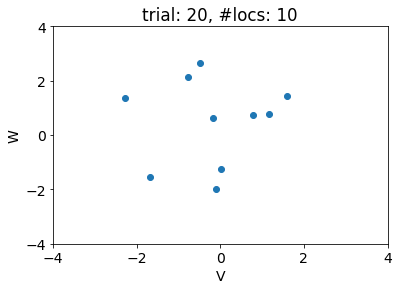

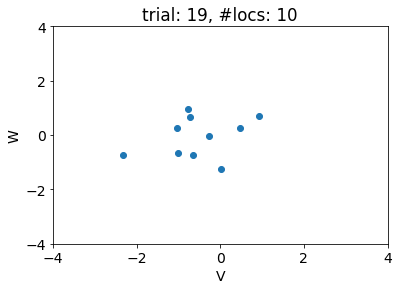

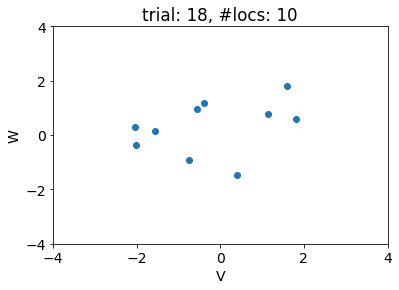

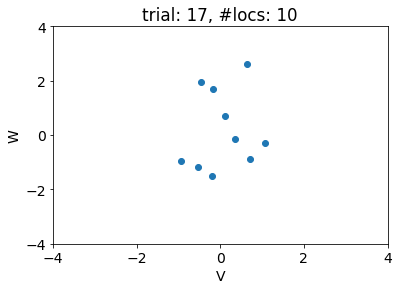

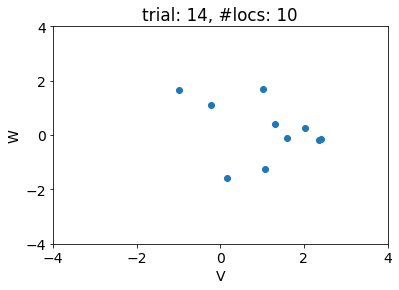

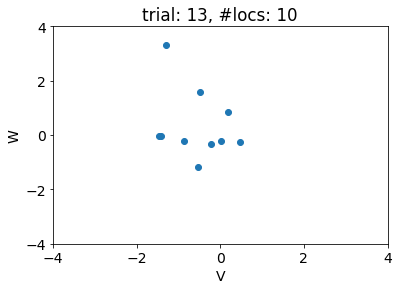

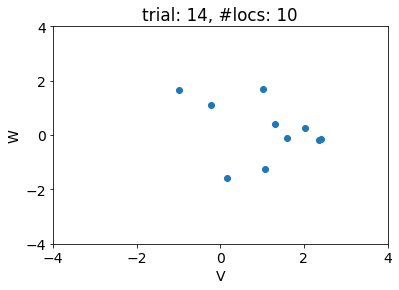

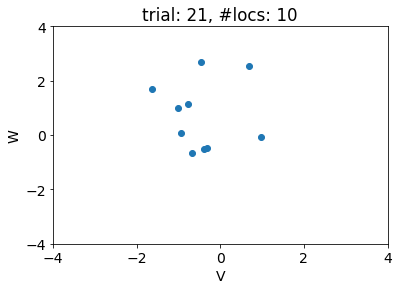

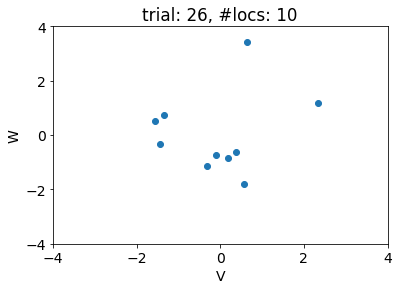

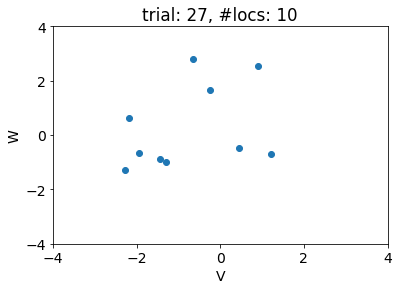

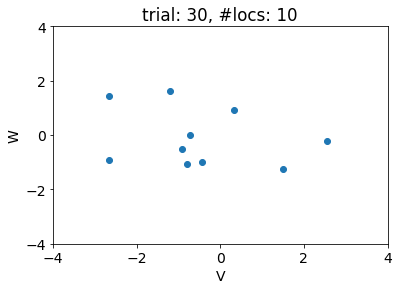

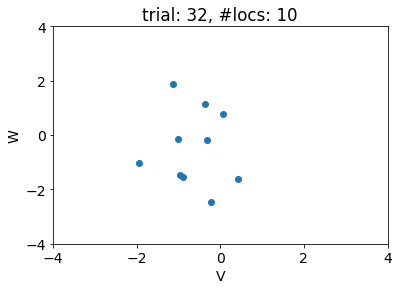

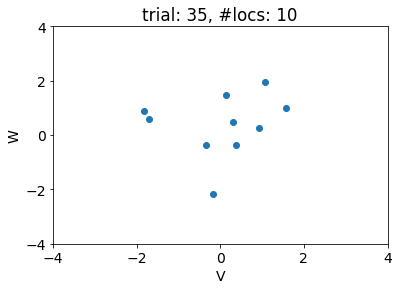

In [40]:
from ipywidgets import interact, fixed
interact(plot_opt_VW_trial, r=(0, reps-1, 1))

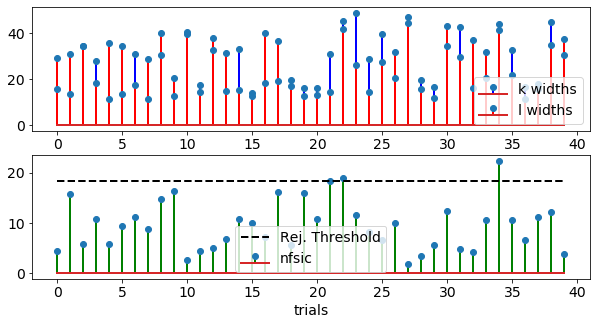

In [47]:
# plot Gaussian widths of all trials
gwxs = np.array([nf.k.sigma2 for nf in rep_nfsics])
gwys = np.array([nf.l.sigma2 for nf in rep_nfsics])
upto_trials = min(len(gwxs), 40)

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(2, 1, 1)

plt.stem(range(upto_trials), gwxs[:upto_trials], 'bo-', label='k widths', use_line_collection=True)
plt.stem(range(upto_trials), gwys[:upto_trials], 'ro-', label='l widths', use_line_collection=True)
plt.legend()

thresh = stats.chi2.isf(alpha, df=J)
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.stem(range(upto_trials), rep_stats[:upto_trials], 'go-', label='nfsic', use_line_collection=True)
plt.plot(range(upto_trials), np.ones(upto_trials)*thresh, 'k--', label='Rej. Threshold')
plt.xlabel('trials')
plt.legend()

In [49]:
r = 31
print('trial %d: gwx = %5.4g, gwy = %5.4g, stat = %5.4g'%(r, gwxs[r], gwys[r], rep_stats[r]))

trial 31: gwx = 42.46, gwy = 29.37, stat = 4.864


In [50]:
x, y = ps.sample(2000, seed=3).xy()
gwx2 = util.sampled_median_distance(x, 1000)**2
gwy2 = util.sampled_median_distance(y, 1000)**2

In [51]:
gwy2

38.30776568375564